# Glambie anaylsis


## Setup


In [1]:
import os
import pandas as pd
import numpy as np
from pathlib import Path
import glob
from collections import defaultdict
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import statsmodels.api as sm
from scipy import stats
from scipy.stats import pearsonr, spearmanr
import pymannkendall as mk
import warnings
import geopandas as gpd
import cartopy.crs as ccrs
import cartopy.feature as cfeature

warnings.filterwarnings("ignore", category=FutureWarning)

# Paths
input_dir = Path("input")
output_dir = Path("output")
input_rel = input_dir / "glambie_reference"
input_maps = input_dir / "maps"
input_datasets = input_dir / "input_datasets"
glambie_runs = input_dir / "glambie_runs"
output_sensitivity = output_dir / "sensitivity"
output_rel = output_dir / "relative_change"
output_dir_datasets = output_dir / "datasets"

## Dataset comparison plots


Plot input data, colored by inclusion (green shades) and exclusion (red shades) of datasets used to produce the results of the paper.

In [ ]:
columns = {'start_dates', 'end_dates', 'changes', 'errors'}
included_colors = ['#2ecc71', '#27ae60', '#229954', '#1e8449', '#196f3d']
excluded_colors = ['#e74c3c', '#c0392b', '#a93226', '#922b21', '#7b241c']

# included_colors = ['#2ecc71', '#00acc1', '#558b2f', '#26a69a', '#0277bd', '#7cb342', '#00695c', '#43a047', '#00838f', '#1b5e20']
# excluded_colors = ['#e53935', '#fb8c00', '#d81b60', '#8d6e63', '#f4511e', '#ad1457', '#c62828', '#ef6c00', '#e91e63', '#6d4c41']

# Load excluded list
excluded_df = pd.read_csv(str(input_datasets / 'excluded_datasets_list.csv'))
# excluded_df = excluded_df[excluded_df['inclusion_possible'].str.strip().str.lower() == 'no'] # plot only problematic datasets as "excluded"

excluded_set = set()
for _, row in excluded_df.iterrows():
    region = row['region']
    data_group = row['data_group']
    dataset = str(row['dataset']).lower()

    if data_group == 'demdiff_and_glaciological':
        excluded_set.add((region, 'demdiff', dataset))
        excluded_set.add((region, 'glaciological', dataset))
    else:
        excluded_set.add((region, data_group, dataset))

# Datasets to completely remove from plots
skip_datasets = set()

# Load all datasets
datasets = []
base_dir = input_datasets
skip_files = {'excluded_datasets_list.csv'}
all_csv_files = [f for f in base_dir.rglob('*.csv') if f.name not in skip_files]

for csv_file in all_csv_files:
    try:
        df = pd.read_csv(csv_file)
        if not columns.issubset(df.columns):
            continue

        parts = csv_file.parts
        if len(parts) < 3:
            continue

        region = parts[-3]
        data_group = parts[-2]
        dataset_name = csv_file.stem

        if dataset_name in skip_datasets:
            continue

        unit = 'Gt' if data_group == 'gravimetry' else 'm'
        is_excluded = (region, data_group, dataset_name.lower()) in excluded_set

        datasets.append({
            'region': region,
            'data_group': data_group,
            'dataset': dataset_name,
            'unit': unit,
            'is_excluded': is_excluded,
            'data': df,
            'filepath': csv_file
        })
    except Exception:
        continue

# Group by (region, unit)
grouped = defaultdict(list)
for ds in datasets:
    grouped[(ds['region'], ds['unit'])].append(ds)

# Plot per group
for (region, unit), group_datasets in sorted(grouped.items()):
    print(f"Plotting {region, unit}")
    if not group_datasets:
        continue

    fig, ax = plt.subplots(figsize=(8, 5))

    included = [ds for ds in group_datasets if not ds['is_excluded']]
    excluded = [ds for ds in group_datasets if ds['is_excluded']]

    # Included
    for idx, ds in enumerate(included):
        color = included_colors[idx % len(included_colors)]
        dfp = ds['data'].copy()

        dfp['time'] = (dfp['start_dates'] + dfp['end_dates']) / 2
        dfp['errors_abs'] = dfp['errors'].abs()
        dfp = dfp.sort_values('time').reset_index(drop=True)
        if len(dfp) == 0:
            continue

        x_lines, y_lines = [], []
        for _, row in dfp.iterrows():
            x_lines.extend([row['start_dates'], row['end_dates'], np.nan])
            y_lines.extend([row['changes'], row['changes'], np.nan])
        ax.plot(x_lines, y_lines, '-', linewidth=2, alpha=0.7, color=color)

        for _, row in dfp.iterrows():
            x_ribbon = [row['start_dates'], row['end_dates'], row['end_dates'], row['start_dates']]
            y_ribbon = [
                row['changes'] - row['errors_abs'],
                row['changes'] - row['errors_abs'],
                row['changes'] + row['errors_abs'],
                row['changes'] + row['errors_abs'],
            ]
            ax.fill(x_ribbon, y_ribbon, color=color, alpha=0.2, edgecolor='none')

    # Excluded
    for idx, ds in enumerate(excluded):
        color = excluded_colors[idx % len(excluded_colors)]
        dfp = ds['data'].copy()

        dfp['time'] = (dfp['start_dates'] + dfp['end_dates']) / 2
        dfp['errors_abs'] = dfp['errors'].abs()
        dfp = dfp.sort_values('time').reset_index(drop=True)
        if len(dfp) == 0:
            continue

        x_lines, y_lines = [], []
        for _, row in dfp.iterrows():
            x_lines.extend([row['start_dates'], row['end_dates'], np.nan])
            y_lines.extend([row['changes'], row['changes'], np.nan])
        ax.plot(x_lines, y_lines, '-', linewidth=2, alpha=0.7, color=color)

        for _, row in dfp.iterrows():
            x_ribbon = [row['start_dates'], row['end_dates'], row['end_dates'], row['start_dates']]
            y_ribbon = [
                row['changes'] - row['errors_abs'],
                row['changes'] - row['errors_abs'],
                row['changes'] + row['errors_abs'],
                row['changes'] + row['errors_abs'],
            ]
            ax.fill(x_ribbon, y_ribbon, color=color, alpha=0.2, edgecolor='none')

    # Legend
    legend_elements = []
    for idx, ds in enumerate(included):
        color = included_colors[idx % len(included_colors)]
        legend_elements.append(plt.Line2D([0], [0], color=color, lw=2,
                                         label=f"{ds['dataset']} (Included)"))
    for idx, ds in enumerate(excluded):
        color = excluded_colors[idx % len(excluded_colors)]
        legend_elements.append(plt.Line2D([0], [0], color=color, lw=2,
                                         label=f"{ds['dataset']} (Excluded)"))

    unit_label = 'Gravimetry (Gt)' if unit == 'Gt' else 'All Other Methods (m)'
    ax.set_xlabel('Time (year)')
    ax.set_ylabel(f'Change ({unit})')
    ax.set_title(
        f'{region.replace("_", " ").title()} ({unit_label})')
    ax.grid(True, alpha=0.3, linestyle='--')

    if legend_elements:
        ax.legend(handles=legend_elements, loc='best', fontsize=9, ncol=2)

    plt.tight_layout()

    safe_region = region.replace('/', '_').replace('\\', '_')
    output_path = output_dir_datasets / f"{safe_region}_{unit}.png"
    plt.savefig(output_path, dpi=200, bbox_inches='tight')
    plt.close()

## Sensitivity analysis


Comparison of difference when including all possible input datasets in the algorithm. 
- Root mean squared difference
- Mean absolute difference
- Relative difference in overall mass change
- Absolute difference in overall mass change
- Pearson correlation

### Barcharts

In [4]:
# Paths and configuration
run1 = glambie_runs / "Reanalysis_RGI_6_default"
run2 = glambie_runs / "Reanalysis_RGI_6_including_most"

glacier_mass_file = input_rel / "glacier_mass_2000.csv"
glacier_mass_df = pd.read_csv(str(glacier_mass_file), sep=";")
glacier_mass_dict = dict(zip(glacier_mass_df["Region"], glacier_mass_df["Mass"]))

# Region mappings
regions_bar = {
    "1_alaska": "Alaska",
    "2_western_canada_us": "W. Canada & US",
    "3_arctic_canada_north": "Arctic Canada N.",
    "4_arctic_canada_south": "Arctic Canada S.",
    "5_greenland_periphery": "Greenland Per.",
    "6_iceland": "Iceland",
    "7_svalbard": "Svalbard",
    "8_scandinavia": "Scandinavia",
    "9_russian_arctic": "Russian Arctic",
    "10_north_asia": "North Asia",
    "11_central_europe": "Central Europe",
    "12_caucasus_middle_east": "Caucasus & M.E.",
    "13_central_asia": "Central Asia",
    "14_south_asia_west": "South Asia W.",
    "15_south_asia_east": "South Asia E.",
    "16_low_latitudes": "Low Latitudes",
    "17_southern_andes": "Southern Andes",
    "18_new_zealand": "New Zealand",
    "19_antarctic_and_subantarctic": "Antarctic & Sub.",
}

mass_lookup = {
    "Alaska": "Alaska",
    "W. Canada & US": "Western Canada and USA",
    "Arctic Canada N.": "Arctic Canada north",
    "Arctic Canada S.": "Arctic Canada south",
    "Greenland Per.": "Greenland periphery",
    "Iceland": "Iceland",
    "Svalbard": "Svalbard and Jan Mayen",
    "Scandinavia": "Scandinavia",
    "Russian Arctic": "Russian Arctic",
    "North Asia": "North Asia",
    "Central Europe": "Central Europe",
    "Caucasus & M.E.": "Caucasus and Middle East",
    "Central Asia": "Central Asia",
    "South Asia W.": "South Asia west",
    "South Asia E.": "South Asia east",
    "Low Latitudes": "Low latitudes",
    "Southern Andes": "Southern Andes",
    "New Zealand": "New Zealand",
    "Antarctic & Sub.": "Antarctic and subantarctic islands",
    "Global": "Global",
}

regions_map = {
    "1_alaska":                      ("Alaska",            63.0, -150.0, 1),
    "2_western_canada_us":           ("W. Canada & US",    50.0, -122.0, 2),
    "3_arctic_canada_north":         ("Arctic Canada N.",  77.0,  -82.0, 3),
    "4_arctic_canada_south":         ("Arctic Canada S.",  66.0,  -70.0, 4),
    "5_greenland_periphery":         ("Greenland Per.",    72.0,  -42.0, 5),
    "6_iceland":                     ("Iceland",           65.0,  -19.0, 6),
    "7_svalbard":                    ("Svalbard",          78.0,   17.0, 7),
    "8_scandinavia":                 ("Scandinavia",       67.0,   15.0, 8),
    "9_russian_arctic":              ("Russian Arctic",    77.0,   60.0, 9),
    "10_north_asia":                 ("North Asia",        50.0,   90.0, 10),
    "11_central_europe":             ("Central Europe",    47.0,   11.0, 11),
    "12_caucasus_middle_east":       ("Caucasus & M.E.",   42.0,   44.0, 12),
    "13_central_asia":               ("Central Asia",      40.0,   75.0, 13),
    "14_south_asia_west":            ("South Asia W.",     35.0,   74.0, 14),
    "15_south_asia_east":            ("South Asia E.",     30.0,   90.0, 15),
    "16_low_latitudes":              ("Low Latitudes",     -1.0,  -78.0, 16),
    "17_southern_andes":             ("Southern Andes",   -47.0,  -73.0, 17),
    "18_new_zealand":                ("New Zealand",      -44.0,  170.0, 18),
    "19_antarctic_and_subantarctic": ("Antarctic & Sub.", -70.0,    0.0, 19),
}

label_positions = {
    "Alaska":            (-170.0, 55.0),
    "W. Canada & US":    (-140.0, 42.0),
    "Arctic Canada N.":  (-100.0, 82.0),
    "Arctic Canada S.":  (-85.0, 72.0),
    "Greenland Per.":    (-50.0, 78.0),
    "Iceland":           (-30.0, 68.0),
    "Svalbard":          (10.0, 82.0),
    "Scandinavia":       (5.0, 72.0),
    "Russian Arctic":    (70.0, 82.0),
    "North Asia":        (110.0, 55.0),
    "Central Europe":    (0.0, 50.0),
    "Caucasus & M.E.":   (55.0, 48.0),
    "Central Asia":      (85.0, 45.0),
    "South Asia W.":     (65.0, 30.0),
    "South Asia E.":     (100.0, 25.0),
    "Low Latitudes":     (-90.0, -8.0),
    "Southern Andes":    (-80.0, -52.0),
    "New Zealand":       (175.0, -50.0),
    "Antarctic & Sub.":  (-10.0, -75.0),
}

def compute_all_metrics(df1, df2, glacier_mass):
    merged = pd.merge(df1, df2, on="start_dates", suffixes=("_run1", "_run2"))
    diff = merged["changes_run1"] - merged["changes_run2"]
    rmse = np.sqrt(np.mean(diff ** 2))
    mae = np.mean(np.abs(diff))
    cumul_run1 = merged["changes_run1"].sum()
    cumul_run2 = merged["changes_run2"].sum()
    if abs(cumul_run1) > 0.01:
        rel_diff = (cumul_run2 - cumul_run1) / abs(cumul_run1) * 100.0
    else:
        rel_diff = 0.0
    abs_diff = cumul_run2 - cumul_run1
    rmse_pct = (rmse / glacier_mass * 100.0) if glacier_mass else 0.0
    try:
        corr, _ = spearmanr(df1["changes"], df2["changes"])
    except:
        corr = 0
    return rmse, mae, rel_diff, abs_diff, rmse_pct, corr

# Initialize lists to store metrics
region_names = []
rmse_values = []
mae_values = []
rel_diff_values = []
rmse_pct_values = []
abs_diff_values = []
corr_values = []  # New list for correlation values

for region_dir, display_name in regions_bar.items():
    region_key = "_".join(region_dir.split("_")[1:])
    csv1 = run1 / region_dir / "consensus" / "csvs" / f"consensus_calendar_year_gt_{region_key}.csv"
    csv2 = run2 / region_dir / "consensus" / "csvs" / f"consensus_calendar_year_gt_{region_key}.csv"

    df1 = pd.read_csv(str(csv1))
    df2 = pd.read_csv(str(csv2))

    mass_key = mass_lookup.get(display_name, display_name)
    glacier_mass = glacier_mass_dict.get(mass_key, None)

    rmse, mae, rel_diff, abs_diff, rmse_pct, corr = compute_all_metrics(df1, df2, glacier_mass)

    region_names.append(display_name)
    rmse_values.append(rmse)
    mae_values.append(mae)
    rel_diff_values.append(rel_diff)
    rmse_pct_values.append(rmse_pct)
    abs_diff_values.append(abs_diff)
    corr_values.append(corr)

# Compute metrics for the global data
csv1_global = run1 / "0_global" / "consensus" / "csvs" / "global_gt.csv"
csv2_global = run2 / "0_global" / "consensus" / "csvs" / "global_gt.csv"
df1 = pd.read_csv(str(csv1_global))
df2 = pd.read_csv(str(csv2_global))
rmse, mae, rel_diff, abs_diff, rmse_pct, corr = compute_all_metrics(df1, df2, glacier_mass_dict.get("Global", None))
region_names.append("Global")
rmse_values.append(rmse)
mae_values.append(mae)
rel_diff_values.append(rel_diff)
rmse_pct_values.append(rmse_pct)
abs_diff_values.append(abs_diff)
corr_values.append(corr)

# Plotting code for RMSE, MAE, rel_diff, abs_diff (unchanged)
fig1, ax1 = plt.subplots(figsize=(14, 7))
bars1 = ax1.barh(range(len(region_names)), rmse_values)
ax1.set_yticks(range(len(region_names)))
ax1.set_yticklabels(region_names)
ax1.invert_yaxis()
ax1.set_xlabel("RMSE of Mass Change Difference (Gt)")
ax1.set_title("RMSE Difference \n(default vs. all datasets)")
max_rmse = max(rmse_values)
for i, (val, bar) in enumerate(zip(rmse_values, bars1)):
    ax1.text(val + 0.02 * max_rmse, i, f"{val:.2f}", va="center")
ax1.set_xlim(0, max_rmse * 1.15)
fig1.tight_layout()
# Removing for now because too abstract to be useful
# path1 = output_sensitivity / "rmse_difference_between_runs.png"
# fig1.savefig(str(path1), dpi=200, bbox_inches="tight")

fig2, ax2 = plt.subplots(figsize=(14, 7))
bars2 = ax2.barh(range(len(region_names)), mae_values)
ax2.set_yticks(range(len(region_names)))
ax2.set_yticklabels(region_names)
ax2.invert_yaxis()
ax2.set_xlabel("MAE of Mass Change Difference (Gt)")
ax2.set_title("MAE Difference \n(default vs. all datasets)")
max_mae = max(mae_values)
for i, (val, bar) in enumerate(zip(mae_values, bars2)):
    ax2.text(val + 0.02 * max_mae, i, f"{val:.2f}", va="center")
ax2.set_xlim(0, max_mae * 1.15)
fig2.tight_layout()
# Removing for now because too abstract to be useful
# path2 = output_sensitivity / "mae_difference_between_runs.png"
# fig2.savefig(str(path2), dpi=200, bbox_inches="tight")

fig3, ax3 = plt.subplots(figsize=(14, 7))
bars3 = ax3.barh(range(len(region_names)), rel_diff_values)
ax3.set_yticks(range(len(region_names)))
ax3.set_yticklabels(region_names)
ax3.invert_yaxis()
ax3.set_xlabel("Relative Change in Cumulative Mass Loss (%)")
ax3.set_title("Relative Difference in Total Mass Change\n"
              "(default vs. all datasets; positive = more loss, negative = less loss)")
ax3.axvline(0, color="black", linewidth=0.8)
max_abs_rel = max(abs(v) for v in rel_diff_values)
for i, (val, bar) in enumerate(zip(rel_diff_values, bars3)):
    if val >= 0:
        ax3.text(val + 0.02 * max_abs_rel, i, f"+{val:.1f}%", va="center")
    else:
        ax3.text(val - 0.02 * max_abs_rel, i, f"{val:.1f}%", va="center", ha="right")
pad = max_abs_rel * 0.15
ax3.set_xlim(min(rel_diff_values) - pad, max(rel_diff_values) + pad)
fig3.tight_layout()
path3 = output_sensitivity / "relative_difference_between_runs.png"
fig3.savefig(str(path3), dpi=200, bbox_inches="tight")

fig4, ax4 = plt.subplots(figsize=(14, 7))
bars4 = ax4.barh(range(len(region_names)), abs_diff_values)
ax4.set_yticks(range(len(region_names)))
ax4.set_yticklabels(region_names)
ax4.invert_yaxis()
ax4.set_xlabel("Absolute Mass Change Difference (Gt)")
ax4.set_title("Absolute Mass Change Difference \n(default vs. all datasets)")
ax4.axvline(0, color="black", linewidth=0.8)
max_abs_diff = max(abs(v) for v in abs_diff_values)
for i, (val, rel, bar) in enumerate(zip(abs_diff_values, rel_diff_values, bars4)):
    if val >= 0:
        ax4.text(val + 0.02 * max_abs_diff, i, f"+{val:.2f} ({rel:+.1f}%)", va="center")
    else:
        ax4.text(val - 0.02 * max_abs_diff, i, f"{val:.2f} ({rel:+.1f}%)", va="center", ha="right")
min_val = min(abs_diff_values)
max_val = max(abs_diff_values)
pad = max_abs_diff * 0.30
ax4.set_xlim(min_val - pad, max_val + pad)
fig4.tight_layout()
path4 = output_sensitivity / "absolute_difference_between_runs.png"
fig4.savefig(str(path4), dpi=200, bbox_inches="tight")

# New plot for correlation with annotations
fig5, ax5 = plt.subplots(figsize=(14, 7))
bars5 = ax5.barh(range(len(region_names)), corr_values)
ax5.set_yticks(range(len(region_names)))
ax5.set_yticklabels(region_names)
ax5.invert_yaxis()
ax5.set_xlabel("Correlation Coefficient")
ax5.set_title("Correlation between Runs\n(default vs. all datasets)")
ax5.set_xlim(-0.1, 1.1)  # Slightly extend the x-axis to fit annotations

# Add annotations for correlation values
for i, (val, bar) in enumerate(zip(corr_values, bars5)):
    if val >= 0:
        ax5.text(val + 0.02, i, f"{val:.2f}", va="center")
    else:
        ax5.text(val + 0.08, i, f"{val:.2f}", va="center", ha="right")

fig5.tight_layout()
path5 = output_sensitivity / "correlation_between_runs.png"
fig5.savefig(str(path5), dpi=200, bbox_inches="tight")
plt.close('all')

### Map visualization

Create maps which show differences between dataset inclusions per region. 
- Root mean squared difference
- Mean absolute difference
- Relative difference in overall mass change
- Absolute difference in overall mass change

In [7]:
# Map plots
glacreg_path = input_maps / "GlacReg_2023" / "GTN-G_202307_o1regions.shp"
glacier_regions = gpd.read_file(str(glacreg_path))

data = []
for i, (region_dir, (display_name, lat, lon, region_num)) in enumerate(regions_map.items()):
    data.append({
        "name": display_name,
        "lat": lat,
        "lon": lon,
        "region_num": region_num,
        "rmse": rmse_values[i],
        "mae": mae_values[i],
        "rel_diff": rel_diff_values[i],
        "abs_diff": abs_diff_values[i],
        "corr": corr_values[i],
    })

df = pd.DataFrame(data)

# Global is the last element in the barchart lists
global_metrics = {
    "rmse": rmse_values[-1],
    "mae": mae_values[-1],
    "rel_diff": rel_diff_values[-1],
    "abs_diff": abs_diff_values[-1],
    "corr": corr_values[-1],
}

map_configs = [
    # {
    #     "metric": "rmse",
    #     "title": "RMSE Difference Between Glambie Runs\n(default vs. all datasets)",
    #     "cmap": "YlOrRd",
    #     "label": "RMSE (Gt)",
    #     "diverging": False,
    #     "output": "map_rmse_difference.png",
    #     "fmt": ".2f",
    #     "unit": " Gt",
    # },
    # {
    #     "metric": "mae",
    #     "title": "MAE Difference Between Glambie Runs\n(default vs. all datasets)",
    #     "cmap": "YlOrRd",
    #     "label": "MAE (Gt)",
    #     "diverging": False,
    #     "output": "map_mae_difference.png",
    #     "fmt": ".2f",
    #     "unit": " Gt",
    # },
    {
        "metric": "rel_diff",
        "title": "Relative Difference in Total Mass Change\n(default vs. all datasets)",
        "cmap": "RdBu_r",
        "label": "Relative Difference (%)",
        "diverging": True,
        "output": "map_relative_difference.png",
        "fmt": "+.1f",
        "unit": "%",
    },
    {
        "metric": "abs_diff",
        "title": "Absolute Mass Change Difference Between Glambie Runs\n(default vs. all datasets)",
        "cmap": "RdBu_r",
        "label": "Absolute Difference (Gt)",
        "diverging": True,
        "output": "map_absolute_difference.png",
        "fmt": "+.2f",
        "unit": " Gt",
    },
    {
        "metric": "corr",
        "title": "Correlation Between Glambie Runs\n(default vs. all datasets)",
        "cmap": "RdYlGn",
        "label": "Correlation",
        "diverging": False,
        "output": "map_correlation.png",
        "fmt": ".2f",
        "unit": "",
    },
]

for cfg in map_configs:
    metric = cfg["metric"]
    title = cfg["title"]
    cmap = cfg["cmap"]
    label = cfg["label"]
    diverging = cfg["diverging"]
    output_path = output_sensitivity / cfg["output"]
    fmt = cfg["fmt"]
    unit = cfg["unit"]

    values = df[metric].values
    global_val = global_metrics.get(metric, None)

    fig = plt.figure(figsize=(20, 11))
    ax = fig.add_subplot(1, 1, 1, projection=ccrs.Robinson())

    ax.add_feature(cfeature.OCEAN, facecolor='white', zorder=0)
    ax.add_feature(cfeature.LAND, facecolor='#e0e0e0', edgecolor='#aaaaaa', linewidth=0.3, zorder=1)
    ax.add_feature(cfeature.COASTLINE, linewidth=0.4, edgecolor='#666666', zorder=2)

    glaciers = cfeature.NaturalEarthFeature(
        'physical', 'glaciated_areas', '50m',
        edgecolor='#2e5f7f', facecolor='#4a8fc4', linewidth=0.2
    )
    ax.add_feature(glaciers, zorder=3, alpha=0.7)

    if glacier_regions is not None:
        ax.add_geometries(
            glacier_regions.geometry,
            crs=ccrs.PlateCarree(),
            facecolor='none',
            edgecolor='#5a5a5a',
            linewidth=1.0,
            linestyle='--',
            zorder=4,
            alpha=0.6
        )
    ax.set_global()

    vals = np.array(values)
    abs_vals = np.abs(vals)

    if global_val is not None:
        size_scale = max(abs_vals.max(), abs(global_val))
    else:
        size_scale = abs_vals.max()

    sizes = (abs_vals / size_scale) * 5000

    if diverging:
        all_vals = list(vals) + ([global_val] if global_val is not None else [])
        vmax_abs = max(abs(min(all_vals)), abs(max(all_vals)))
        vmin, vmax = -vmax_abs, vmax_abs
        norm = mcolors.TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)
    else:
        vmin = 0
        all_vals = list(vals) + ([global_val] if global_val is not None else [])
        vmax = max(all_vals)
        norm = mcolors.Normalize(vmin=vmin, vmax=vmax)

    sc = ax.scatter(
        df["lon"], df["lat"],
        c=vals, s=sizes,
        cmap=cmap, norm=norm,
        edgecolors="0.2", linewidths=1.0,
        zorder=8, alpha=0.75,
        transform=ccrs.PlateCarree()
    )

    for _, row in df.iterrows():
        region_name = row["name"]
        val = row[metric]
        val_str = f"{val:{fmt}}{unit}"

        if region_name in label_positions:
            label_lon, label_lat = label_positions[region_name]

            ax.text(
                label_lon, label_lat,
                f"{region_name}\n{val_str}",
                fontsize=7, ha="center", va='center',
                color="0.1",
                bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="0.4", alpha=0.85, linewidth=0.5),
                transform=ccrs.PlateCarree(),
                zorder=12
            )

            ax.plot(
                [label_lon, row["lon"]], [label_lat, row["lat"]],
                color='0.5', linewidth=0.4, linestyle='-', alpha=0.5,
                transform=ccrs.PlateCarree(),
                zorder=7
            )

    if global_val is not None:
        global_lon, global_lat = 0.0, -20.0
        global_size = (abs(global_val) / size_scale) * 5000

        ax.scatter(
            [global_lon], [global_lat],
            c=[global_val], s=[global_size * 1.5],
            cmap=cmap, norm=norm,
            edgecolors="0.1", linewidths=1.0,
            zorder=11, alpha=0.9,
            marker="o",
            transform=ccrs.PlateCarree()
        )

        val_str = f"{global_val:{fmt}}{unit}"
        ax.text(
            global_lon, global_lat - 8,
            f"Global\n{val_str}",
            fontsize=9, fontweight="bold", ha="center", va='top',
            color="0.05",
            bbox=dict(boxstyle="round,pad=0.35", fc="white", ec="0.3", alpha=0.95, linewidth=1),
            transform=ccrs.PlateCarree(),
            zorder=12
        )

    cb = plt.colorbar(sc, ax=ax, shrink=0.5, pad=0.03, aspect=20, orientation='vertical')
    cb.set_label(label, fontsize=11)
    cb.ax.tick_params(labelsize=9)

    ax.set_title(title, fontsize=13, pad=15)

    fig.tight_layout()
    fig.savefig(str(output_path), dpi=200)
    plt.close(fig)

### Refine into single map

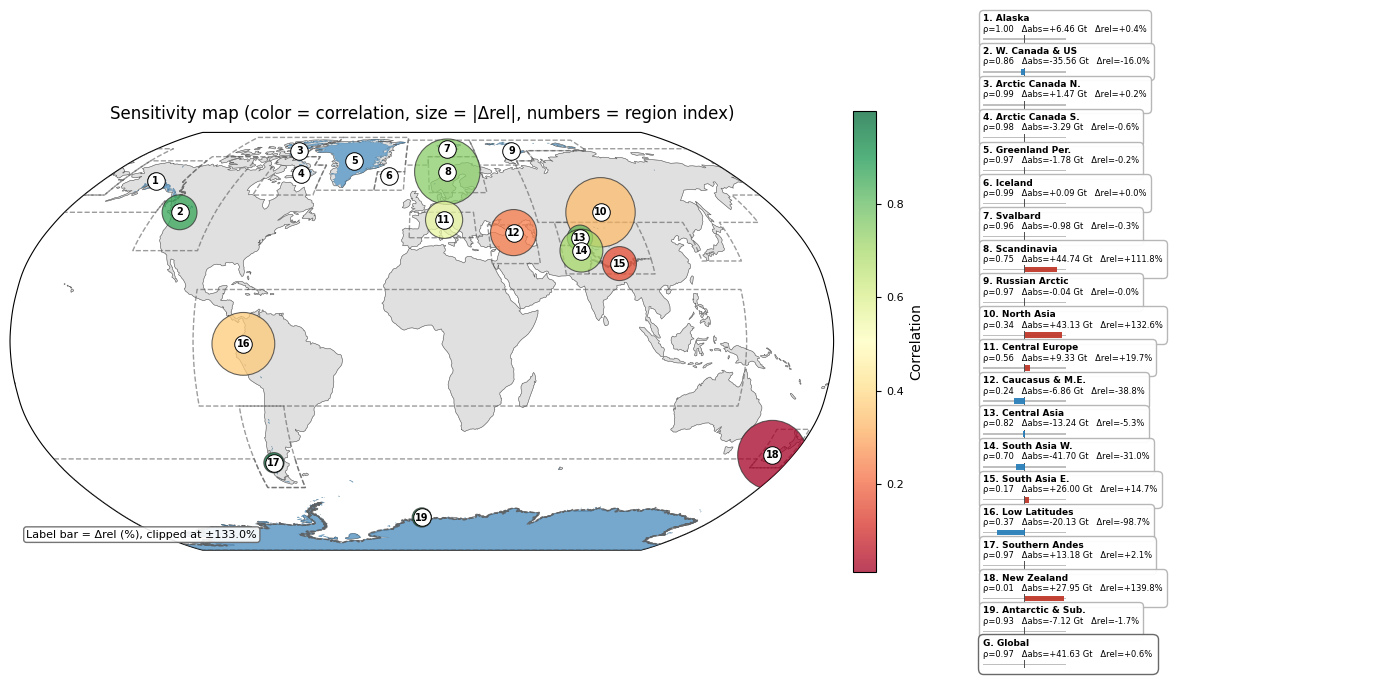

In [46]:
import numpy as np
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.patches import Circle
from matplotlib.offsetbox import AnnotationBbox, DrawingArea, VPacker, TextArea
from matplotlib.patches import Rectangle
REL_CAP_Q = 95
DOT_MIN, DOT_MAX = 80, 2500
BAR_W, BAR_H = 60, 6
LABEL_FONTSIZE = 6
BOX_ALPHA = 0.95
CONNECTOR_LW = 0.35

SAVE = True
OUT_NAME = "map_numbered_panel.png"
DPI = 300

def make_bar(rel_v, cap, width=BAR_W, height=BAR_H):
    da = DrawingArea(width, height, 0, 0)
    mid = width // 2
    da.add_artist(Rectangle((0, height/2 - 0.5), width, 1.0, fc="0.75", ec="none"))
    da.add_artist(Rectangle((mid - 0.5, 0), 1.0, height, fc="0.25", ec="none", alpha=0.9))

    cap = float(cap) if cap and np.isfinite(cap) else 1.0
    rel_clipped = float(np.clip(rel_v, -cap, cap))
    frac = abs(rel_clipped) / cap if cap else 0.0
    half = int(frac * (width/2 - 2))
    color = "#c0392b" if rel_clipped >= 0 else "#2980b9"

    if half > 0:
        if rel_clipped >= 0:
            x0, w = mid, half
        else:
            x0, w = mid - half, half
        da.add_artist(Rectangle((x0, 1), w, height-2, fc=color, ec="none", alpha=0.95))
    return da

def make_panel_entry(num, name, corr_v, rel_v, abs_v, cap):
    header = TextArea(f"{num}. {name}",
                      textprops=dict(size=LABEL_FONTSIZE+0.5, weight="bold"))
    txt = TextArea(f"ρ={corr_v:.2f}   Δabs={abs_v:+.2f} Gt   Δrel={rel_v:+.1f}%",
                   textprops=dict(size=LABEL_FONTSIZE))
    bar = make_bar(rel_v, cap)
    return VPacker(children=[header, txt, bar], align="left", pad=0, sep=1)

# ---------- Figure layout: map + side panel ----------

fig = plt.figure(figsize=(14, 7))
gs = fig.add_gridspec(1, 2, width_ratios=[3.0, 1.2])
ax = fig.add_subplot(gs[0, 0], projection=ccrs.Robinson())
axp = fig.add_subplot(gs[0, 1])  # panel axis
axp.axis("off")

# Basemap
ax.add_feature(cfeature.OCEAN, facecolor="white", zorder=0)
ax.add_feature(cfeature.LAND, facecolor="#e0e0e0", edgecolor="#aaaaaa", linewidth=0.3, zorder=1)
ax.add_feature(cfeature.COASTLINE, linewidth=0.4, edgecolor="#666666", zorder=2)

glaciers = cfeature.NaturalEarthFeature(
    "physical", "glaciated_areas", "50m",
    edgecolor="#2e5f7f", facecolor="#4a8fc4", linewidth=0.2
)
ax.add_feature(glaciers, zorder=3, alpha=0.7)

if "glacier_regions" in globals() and glacier_regions is not None:
    ax.add_geometries(
        glacier_regions.geometry, crs=ccrs.PlateCarree(),
        facecolor="none", edgecolor="#5a5a5a", linewidth=1.0,
        linestyle="--", zorder=4, alpha=0.6
    )

ax.set_global()

# Data
corr = df["corr"].to_numpy(dtype=float)
rel = df["rel_diff"].to_numpy(dtype=float)

g_corr = float(global_metrics.get("corr", np.nan)) if "global_metrics" in globals() else np.nan
g_rel = float(global_metrics.get("rel_diff", np.nan)) if "global_metrics" in globals() else np.nan
g_abs = float(global_metrics.get("abs_diff", np.nan)) if "global_metrics" in globals() else np.nan

norm_corr = mcolors.Normalize(
    vmin=float(np.nanmin(np.r_[corr, g_corr])),
    vmax=float(np.nanmax(np.r_[corr, g_corr])),
)

abs_rel = np.abs(rel)
rel_cap = np.nanpercentile(np.r_[abs_rel, np.abs(g_rel)], REL_CAP_Q)
rel_cap = float(rel_cap) if np.isfinite(rel_cap) and rel_cap > 0 else 1.0

abs_rel_c = np.clip(abs_rel, 0, rel_cap)
sizes = DOT_MIN + (abs_rel_c / rel_cap) ** 0.7 * (DOT_MAX - DOT_MIN)

# Scatter
sc = ax.scatter(
    df["lon"], df["lat"],
    c=corr, s=sizes,
    cmap="RdYlGn", norm=norm_corr,
    edgecolors="0.2", linewidths=0.8,
    alpha=0.75, zorder=8,
    transform=ccrs.PlateCarree(),
)

# Numbered circles on the map
for idx, row in enumerate(df.itertuples(), start=1):
    lon, lat = float(row.lon), float(row.lat)
    # white circle with black edge + number
    ax.scatter([lon], [lat], s=160, color="white", edgecolor="black",
               linewidth=0.7, zorder=12, transform=ccrs.PlateCarree())
    ax.text(lon, lat, str(idx),
            ha="center", va="center", fontsize=7, weight="bold",
            zorder=13, transform=ccrs.PlateCarree())

# Side panel with detailed entries
pc = axp.transAxes
n = len(df)
rows = n + (1 if np.isfinite(g_corr) else 0)
y_step = 1.0 / max(rows, 1)

for idx, row in enumerate(df.itertuples(), start=1):
    entry = make_panel_entry(
        idx, row.name,
        float(row.corr),
        float(row.rel_diff),
        float(row.abs_diff),
        rel_cap,
    )
    y = 1.0 - (idx - 0.5) * y_step
    ab = AnnotationBbox(
        entry, (0.0, y),
        xycoords=pc,
        box_alignment=(0, 0.5),
        frameon=True,
        bboxprops=dict(boxstyle="round,pad=0.3", fc="white", ec="0.7", alpha=BOX_ALPHA),
        pad=0,
        zorder=5,
    )
    axp.add_artist(ab)


# Optional: global entry at bottom of panel
if np.isfinite(g_corr) and np.isfinite(g_rel):
    entry = make_panel_entry("G", "Global", g_corr, g_rel, g_abs, rel_cap)
    y = 1.0 - (rows - 0.5) * y_step
    ab = AnnotationBbox(
        entry, (0.0, y),
        xycoords=pc,
        box_alignment=(0, 0.5),
        frameon=True,
        bboxprops=dict(boxstyle="round,pad=0.4", fc="white", ec="0.4", alpha=0.98),
        pad=0,
        zorder=6,
    )
    axp.add_artist(ab)

# Colorbar & caption
cbar = plt.colorbar(sc, ax=ax, shrink=0.7, pad=0.02, label="Correlation")
cbar.ax.tick_params(labelsize=8)

ax.text(
    0.02, 0.03,
    f"Label bar = Δrel (%), clipped at ±{rel_cap:.1f}%",
    transform=ax.transAxes, fontsize=8,
    bbox=dict(boxstyle="round,pad=0.25", fc="white", ec="0.4", alpha=0.9),
    zorder=20,
)

ax.set_title(
    "Sensitivity map (color = correlation, size = |Δrel|, numbers = region index)",
    fontsize=12, pad=10,
)

plt.tight_layout()
plt.show()

if SAVE:
    fig.savefig(str(output_sensitivity / OUT_NAME), dpi=DPI, bbox_inches="tight")

## Relative change calculations


In [ ]:
glacier_mass_2000_path = input_rel / "glacier_mass_2000.csv"
calendar_years_path = input_rel / "calendar_years"

mass_2000 = pd.read_csv(str(glacier_mass_2000_path), sep=';')
file_to_mass_data = {}
for _, row in mass_2000.iterrows():
    file_to_mass_data[row['File']] = {
        'region': row['Region'],
        'mass': row['Mass'],
        'error': row['Error']
    }
annual_changes = {}

for csv_file in sorted(glob.glob(str(calendar_years_path / "*.csv"))):
    annual_changes[Path(csv_file).name] = pd.read_csv(csv_file)

In [ ]:
# Calculate annual relative change with uncertainty propagation
results = []

for filename, df_changes in sorted(annual_changes.items()):
    matched_mass_data = file_to_mass_data[filename]
    current_mass = matched_mass_data['mass']
    current_mass_error = matched_mass_data['error']

    df_changes_sorted = df_changes.sort_values('start_dates').reset_index(drop=True)

    for idx, row in df_changes_sorted.iterrows():
        annual_change = row['combined_gt']
        annual_change_error = row['combined_gt_errors']

        relative_change = annual_change / current_mass

        # error propagation
        relative_change_error_term1 = (annual_change_error / annual_change) ** 2
        relative_change_error_term2 = (current_mass_error / current_mass) ** 2
        relative_change_error = abs(relative_change) * np.sqrt(relative_change_error_term1 + relative_change_error_term2)

        results.append({
            'region': matched_mass_data['region'],
            'year_start': int(row['start_dates']),
            'year_end': int(row['end_dates']),
            'glacier_mass_at_start': current_mass,
            'glacier_mass_error_at_start': current_mass_error,
            'annual_change_gt': annual_change,
            'annual_change_error': annual_change_error,
            'relative_change': relative_change,
            'relative_change_error': relative_change_error,
            'relative_change_pct': relative_change * 100,
            'relative_change_error_pct': relative_change_error * 100
        })

        current_mass = current_mass + annual_change
        current_mass_error = np.sqrt(current_mass_error**2 + annual_change_error**2)

results_df = pd.DataFrame(results)


### Combined relative change and mass evolution

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(16, 8))
all_regions = sorted(results_df['region'].unique())
global_regions = [r for r in all_regions if r.lower() == 'global']
other_regions = [r for r in all_regions if r.lower() != 'global']

ax1 = axes[0]
for region in global_regions:
    region_data = results_df[results_df['region'] == region].sort_values('year_start')
    ax1.plot(region_data['year_start'], region_data['relative_change_pct'],
             marker='o', label=region, alpha=0.8, linewidth=2, color='darkblue')
    ax1.fill_between(region_data['year_start'],
                      region_data['relative_change_pct'] - region_data['relative_change_error_pct'],
                      region_data['relative_change_pct'] + region_data['relative_change_error_pct'],
                      alpha=0.2, color='darkblue')
ax1.set_xlabel('Year Start', fontsize=12)
ax1.set_ylabel('Relative Change (%)', fontsize=12)
ax1.set_title('Global Annual Relative Glacier Mass Change', fontsize=14)
ax1.legend(fontsize=10, loc='lower left')
ax1.grid(True, alpha=0.3)
ax1.axhline(y=0, color='k', linestyle='--', alpha=0.5)

ax2 = axes[1]
for region in other_regions:
    region_data = results_df[results_df['region'] == region].sort_values('year_start')
    ax2.plot(region_data['year_start'], region_data['relative_change_pct'],
             marker='o', label=region, alpha=0.8, linewidth=2)
    ax2.fill_between(region_data['year_start'],
                      region_data['relative_change_pct'] - region_data['relative_change_error_pct'],
                      region_data['relative_change_pct'] + region_data['relative_change_error_pct'],
                      alpha=0.15)
ax2.set_xlabel('Year Start', fontsize=12)
ax2.set_ylabel('Relative Change (%)', fontsize=12)
ax2.set_title('Regional Annual Relative Glacier Mass Change', fontsize=14)
ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
ax2.grid(True, alpha=0.3)
ax2.axhline(y=0, color='k', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig(output_rel / 'relative_change_plots.png', dpi=300, bbox_inches='tight')
plt.show()


In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(16, 8))
ax3 = axes[0]

for region in global_regions:
    region_data = results_df[results_df['region'] == region].sort_values('year_start')
    ax3.plot(region_data['year_start'], region_data['glacier_mass_at_start'],
             marker='s', label=region, alpha=0.8, linewidth=2, color='darkblue')
    ax3.fill_between(region_data['year_start'],
                      region_data['glacier_mass_at_start'] - region_data['glacier_mass_error_at_start'],
                      region_data['glacier_mass_at_start'] + region_data['glacier_mass_error_at_start'],
                      alpha=0.2, color='darkblue')
ax3.set_xlabel('Year Start', fontsize=12)
ax3.set_ylabel('Glacier Mass (Gt)', fontsize=12)
ax3.set_title('Global Glacier Mass', fontsize=14)
ax3.legend(fontsize=10)
ax3.grid(True, alpha=0.3)
ax3.set_ylim(bottom=0)
ax4 = axes[1]

for region in other_regions:
    region_data = results_df[results_df['region'] == region].sort_values('year_start')
    ax4.plot(region_data['year_start'], region_data['glacier_mass_at_start'],
             marker='s', label=region, alpha=0.8, linewidth=2)
    ax4.fill_between(region_data['year_start'],
                      region_data['glacier_mass_at_start'] - region_data['glacier_mass_error_at_start'],
                      region_data['glacier_mass_at_start'] + region_data['glacier_mass_error_at_start'],
                      alpha=0.15)
ax4.set_xlabel('Year Start', fontsize=12)
ax4.set_ylabel('Glacier Mass (Gt)', fontsize=12)
ax4.set_title('Regional Glacier Mass', fontsize=14)
ax4.legend(bbox_to_anchor=(1, 0.8), loc='upper left', fontsize=9)
ax4.grid(True, alpha=0.3)
ax4.set_ylim(bottom=0)
plt.tight_layout()
plt.savefig(output_rel / 'glacier_mass_evolution.png', dpi=300, bbox_inches='tight')
plt.show()

### Global relative and absolute change with trend test

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))
all_regions = sorted(results_df['region'].unique())
global_regions = [r for r in all_regions if r.lower() == 'global']
for region in global_regions:
    region_data = results_df[results_df['region'] == region].sort_values('year_start')
    ax.plot(region_data['year_start'], region_data['relative_change_pct'],
             marker='o', label=region, alpha=0.8, linewidth=2, color='darkblue')
    ax.fill_between(region_data['year_start'],
                    region_data['relative_change_pct'] - region_data['relative_change_error_pct'],
                    region_data['relative_change_pct'] + region_data['relative_change_error_pct'],
                    alpha=0.2, color='darkblue')
ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('Relative Mass Change (%)', fontsize=12)
ax.set_title('Global Annual Relative Glacier Mass Change', fontsize=14)
ax.grid(True, alpha=0.3)
ax.axhline(y=0, color='k', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig(output_rel / 'global_relative_change_plot.png', dpi=300, bbox_inches='tight')
plt.show()
relative_result = mk.original_test(region_data['relative_change_pct'])
print(relative_result)


In [ ]:
for region in all_regions:
    region_data = results_df[results_df['region'] == region].sort_values('year_start')
    absolute_result = mk.original_test(region_data['relative_change_pct'])
    print(f"{region}: {absolute_result}")


In [ ]:
# Absolute change for comparison
fig, ax = plt.subplots(figsize=(10, 6))
all_regions = sorted(results_df['region'].unique())
global_regions = [r for r in all_regions if r.lower() == 'global']
for region in global_regions:
    region_data = results_df[results_df['region'] == region].sort_values('year_start')
    ax.plot(region_data['year_start'], region_data['annual_change_gt'],
             marker='o', label=region, alpha=0.8, linewidth=2, color='darkblue')
    ax.fill_between(region_data['year_start'],
                    region_data['annual_change_gt'] - region_data['annual_change_error'],
                    region_data['annual_change_gt'] + region_data['annual_change_error'],
                    alpha=0.2, color='darkblue')
ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('Mass Change (Gt)', fontsize=12)
ax.set_title('Global Annual Absolute Glacier Mass Change', fontsize=14)
ax.grid(True, alpha=0.3)
ax.axhline(y=0, color='k', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig(output_rel / 'global_absolute_change_plot.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
for region in all_regions:
    region_data = results_df[results_df['region'] == region].sort_values('year_start')
    absolute_result = mk.original_test(region_data['annual_change_gt'])
    print(f"{region}: {absolute_result}")


In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))
for region in global_regions:
    region_data = results_df[results_df['region'] == region].sort_values('year_start')
    ax.scatter(region_data['annual_change_gt'], region_data['relative_change_pct'],
               marker='o', label=region, alpha=0.8, s=50, color='darkblue')
ax.set_xlabel('Absolute Change (Gt)', fontsize=12)
ax.set_ylabel('Relative Change (%)', fontsize=12)
ax.set_title('Absolute vs Relative Change (Global)', fontsize=14)
ax.grid(True, alpha=0.3)
ax.axhline(y=0, color='k', linestyle='--', alpha=0.5)
ax.axvline(x=0, color='k', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig(output_rel / 'absolute_vs_relative_change.png', dpi=300, bbox_inches='tight')
plt.show()


In [ ]:
global_data = results_df[results_df['region'] == 'Global'].sort_values('year_start')
x = global_data['year_start'].values.astype(float)
y = global_data['relative_change_pct'].values
sigma = global_data['relative_change_error_pct'].values
w = 1.0 / (sigma**2)
X_lin  = sm.add_constant(x)
X_quad = sm.add_constant(np.column_stack([x, x**2]))
m_lin  = sm.WLS(y, X_lin,  weights=w).fit()
m_quad = sm.WLS(y, X_quad, weights=w).fit()
print("AIC linear:", m_lin.aic)
print("AIC quad  :", m_quad.aic)
print("quad term (t^2) coef, p:", m_quad.params[2], m_quad.pvalues[2])


In [ ]:
global_data = results_df[results_df['region'] == 'Global'].sort_values('year_start')
x = global_data['year_start'].values.astype(float)
y = global_data['annual_change_gt'].values
sigma = global_data['annual_change_error'].values
w = 1.0 / (sigma**2)
X_lin  = sm.add_constant(x)
X_quad = sm.add_constant(np.column_stack([x, x**2]))
m_lin  = sm.WLS(y, X_lin,  weights=w).fit()
m_quad = sm.WLS(y, X_quad, weights=w).fit()
print("AIC linear:", m_lin.aic)
print("AIC quad  :", m_quad.aic)
print("quad term (t^2) coef, p:", m_quad.params[2], m_quad.pvalues[2])


### Combined absolute and relative change plots

In [ ]:
all_regions = sorted(results_df['region'].unique())
for region in all_regions:
    fig, ax1 = plt.subplots(figsize=(10, 6))
    region_data = results_df[results_df['region'] == region].sort_values('year_start')

    # Compute relative change from start to end
    start_mass = region_data.iloc[0]['glacier_mass_at_start']
    end_mass = region_data.iloc[-1]['glacier_mass_at_start']
    relative_change = ((end_mass - start_mass) / start_mass) * 100

    # Plot relative change
    ax1.plot(region_data['year_start'], region_data['relative_change_pct'],
             marker='o', label='Relative Change', alpha=0.8, linewidth=2, color='darkblue')
    ax1.fill_between(region_data['year_start'],
                    region_data['relative_change_pct'] - region_data['relative_change_error_pct'],
                    region_data['relative_change_pct'] + region_data['relative_change_error_pct'],
                    alpha=0.2, color='darkblue')
    ax1.set_xlabel('Year', fontsize=12)
    ax1.set_ylabel('Relative Mass Change (%)', fontsize=12)
    ax1.set_title(f'{region} - Glacier Mass Change', fontsize=14)
    ax1.grid(True, alpha=0.3)

    # Create a twin axis for absolute change
    ax2 = ax1.twinx()
    ax2.plot(region_data['year_start'], region_data['annual_change_gt'],
             marker='s', label='Absolute Change', alpha=0.8, linewidth=2, color='crimson')
    ax2.fill_between(region_data['year_start'],
                    region_data['annual_change_gt'] - region_data['annual_change_error'],
                    region_data['annual_change_gt'] + region_data['annual_change_error'],
                    alpha=0.2, color='crimson')
    ax2.set_ylabel('Mass Change (Gt)', fontsize=12)

    # Find the max absolute values for both axes
    max_rel = max(abs(region_data['relative_change_pct'].min()), abs(region_data['relative_change_pct'].max()))
    max_abs = max(abs(region_data['annual_change_gt'].min()), abs(region_data['annual_change_gt'].max()))

    # Set y-limits to be symmetric around zero
    ax1.set_ylim(-max_rel * 1.55, max_rel * 1.4)
    ax2.set_ylim(-max_abs * 1.55, max_abs * 1.4)

    # Draw zero lines
    ax1.axhline(y=0, color='k', linestyle='--', alpha=0.5)
    ax2.axhline(y=0, color='k', linestyle='--', alpha=0.5)

    # Combine legends from both axes
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='lower left')

    # Add annotation for total relative change
    ax1.text(0.81, 0.98, f'Total Change: {relative_change:.2f}%',
             transform=ax1.transAxes, verticalalignment='top', fontsize=10,
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    plt.tight_layout()
    #plt.savefig(output_rel / f'{region}_combined_change.png', dpi=300, bbox_inches='tight')
    plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))
for region in global_regions:
    region_data = results_df[results_df['region'] == region].sort_values('year_start')
    ax.plot(region_data['year_start'], region_data['glacier_mass_at_start'],
             marker='s', label=region, alpha=0.8, linewidth=2, color='darkblue')
    ax.fill_between(region_data['year_start'],
                    region_data['glacier_mass_at_start'] - region_data['glacier_mass_error_at_start'],
                    region_data['glacier_mass_at_start'] + region_data['glacier_mass_error_at_start'],
                    alpha=0.2, color='darkblue')
ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('Glacier Mass (Gt)', fontsize=12)
ax.set_title('Global Glacier Mass', fontsize=14)
ax.grid(True, alpha=0.3)
ax.set_ylim(bottom=0)
plt.tight_layout()
plt.savefig(output_rel / 'global_glacier_mass_plot.png', dpi=300, bbox_inches='tight')
plt.show()


### Relative changes per region

In [ ]:
for region in sorted(results_df['region'].unique()):
    region_data = results_df[results_df['region'] == region].sort_values('year_start')
    x = region_data['year_start'].values
    y = region_data['relative_change_pct'].values
    y_err = region_data['relative_change_error_pct'].values

    fig, ax = plt.subplots(figsize=(10, 4))
    ax.plot(x, y, marker='o', linestyle='-', color='darkblue', alpha=0.6)
    ax.fill_between(x, y - y_err, y + y_err, color='darkblue', alpha=0.15)
    y_lower_r = np.nanmin(y - y_err)
    y_upper_r = np.nanmax(y + y_err)
    pad_r = 0.05 * (y_upper_r - y_lower_r) if y_upper_r > y_lower_r else 1.0
    
    ax.set_ylim(y_lower_r - pad_r, y_upper_r + pad_r)
    ax.set_title(f'{region} — Annual Relative Glacier Mass Change (%)')
    ax.set_xlabel('Year Start')
    ax.set_ylabel('Relative Change (%)')
    ax.grid(alpha=0.3)
    
    fname = f"relative_change_{region.replace(' ', '_').replace('/', '_').lower()}.png"
    plt.tight_layout()
    plt.savefig(output_rel / fname, dpi=300, bbox_inches='tight')
    plt.show()


### Mass evolution per region

In [ ]:
for region in sorted(results_df['region'].unique()):
    region_data = results_df[results_df['region'] == region].sort_values('year_start')
    x = region_data['year_start'].values
    y = region_data['glacier_mass_at_start'].values
    y_err = region_data['glacier_mass_error_at_start'].values

    # Compute relative change from start to end
    start_mass = region_data.iloc[0]['glacier_mass_at_start']
    end_mass = region_data.iloc[-1]['glacier_mass_at_start']
    relative_change = ((end_mass - start_mass) / start_mass) * 100

    # Create the plot
    fig, ax = plt.subplots(figsize=(10, 4))
    ax.plot(x, y, marker='s', linestyle='-', alpha=0.8, linewidth=2, color='darkblue')
    ax.fill_between(x, y - y_err, y + y_err, alpha=0.15, color='darkblue')

    # Set y-axis limits with padding
    y_lower_r = np.nanmin(y - y_err)
    y_upper_r = np.nanmax(y + y_err)
    pad_r = 0.05 * (y_upper_r - y_lower_r) if y_upper_r > y_lower_r else 1.0
    ax.set_ylim(y_lower_r - pad_r, y_upper_r + pad_r)

    # Add relative change as text
    ax.text(
        0.8, 0.95,
        f"Relative Change: {relative_change:.1f}%",
        transform=ax.transAxes,
        fontsize=10,
        verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.8)
    )

    ax.set_title(f'{region} — Glacier Mass (Gt)')
    ax.set_xlabel('Year Start')
    ax.set_ylabel('Glacier Mass (Gt)')
    ax.grid(alpha=0.3)

    # Save the figure
    fname = f"glacier_mass_{region.replace(' ', '_').replace('/', '_').lower()}.png"
    plt.tight_layout()
    plt.savefig(output_rel / fname, dpi=300, bbox_inches='tight')
    plt.show()

### Combined relative change and mass evolution

In [ ]:
for region in sorted(results_df['region'].unique()):
    region_data = results_df[results_df['region'] == region].sort_values('year_start')

    # Glacier Mass Data
    x_mass = region_data['year_start'].values
    y_mass = region_data['glacier_mass_at_start'].values
    y_err_mass = region_data['glacier_mass_error_at_start'].values

    # Relative Change Data
    x_rel = region_data['year_start'].values
    y_rel = region_data['relative_change_pct'].values
    y_err_rel = region_data['relative_change_error_pct'].values

    # Compute relative change from start to end for glacier mass
    start_mass = region_data.iloc[0]['glacier_mass_at_start']
    end_mass = region_data.iloc[-1]['glacier_mass_at_start']
    relative_change = ((end_mass - start_mass) / start_mass) * 100

    # Create a figure with two subplots
    fig, (ax2, ax1) = plt.subplots(nrows=2, figsize=(10, 8), sharex=True)

    # --- Glacier Mass Subplot ---
    ax1.plot(x_mass, y_mass, marker='s', linestyle='-', alpha=0.8, linewidth=2, color='darkblue')
    ax1.fill_between(x_mass, y_mass - y_err_mass, y_mass + y_err_mass, alpha=0.15, color='darkblue')

    # Set y-axis limits with padding
    y_lower_mass = np.nanmin(y_mass - y_err_mass)
    y_upper_mass = np.nanmax(y_mass + y_err_mass)
    pad_mass = 0.05 * (y_upper_mass - y_lower_mass) if y_upper_mass > y_lower_mass else 1.0
    ax1.set_ylim(y_lower_mass - pad_mass, y_upper_mass + pad_mass)

    # Add relative change as text
    ax1.text(
        0.8, 0.95,
        f"Relative Change: {relative_change:.1f}%",
        transform=ax1.transAxes,
        fontsize=10,
        verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.8)
    )

    # ax1.set_title(f'{region} — Glacier Mass (Gt)')
    ax1.set_ylabel('Glacier Mass (Gt)')
    ax1.grid(alpha=0.3)

    # Annual Relative Change Subplot
    ax2.plot(x_rel, y_rel, marker='o', linestyle='-', color='darkblue', alpha=0.6)
    ax2.fill_between(x_rel, y_rel - y_err_rel, y_rel + y_err_rel, color='darkblue', alpha=0.15)

    # Set y-axis limits with padding
    y_lower_rel = np.nanmin(y_rel - y_err_rel)
    y_upper_rel = np.nanmax(y_rel + y_err_rel)
    pad_rel = 0.05 * (y_upper_rel - y_lower_rel) if y_upper_rel > y_lower_rel else 1.0
    ax2.set_ylim(y_lower_rel - pad_rel, y_upper_rel + pad_rel)

    ax2.set_title(f'{region}')
    ax1.set_xlabel('Year')
    ax2.set_ylabel('Relative Annual Change (%)')
    ax2.grid(alpha=0.3)

    # Save the figure
    fname = f"combined_{region.replace(' ', '_').replace('/', '_').lower()}.png"
    plt.tight_layout()
    plt.savefig(output_rel / fname, dpi=300, bbox_inches='tight')
    plt.show()

In [ ]:
trend_results = []
for region in sorted(results_df['region'].unique()):
    region_data = results_df[results_df['region'] == region].sort_values('year_start')
    x = region_data['year_start'].values
    y = region_data['relative_change_pct'].values
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
    trend_per_year_pct = slope
    is_significant = p_value < 0.05
    trend_direction = 'increasing' if slope > 0 else 'decreasing'
    trend_results.append({
        'region': region,
        'slope_pct_per_year': round(trend_per_year_pct, 4),
        'intercept': round(intercept, 2),
        'r_squared': round(r_value**2, 4),
        'p_value': round(p_value, 4),
        'std_err': round(std_err, 4),
        'is_significant': is_significant,
        'trend_direction': trend_direction
    })
trend_df = pd.DataFrame(trend_results)
print(trend_df)


In [ ]:
# Export results to CSV
# output_csv = output_rel / 'annual_relative_change_results.csv'
# results_df.to_csv(output_csv, index=False)
# print(f"Results exported to: {output_csv}")


## Visualization of glambie runs


Global


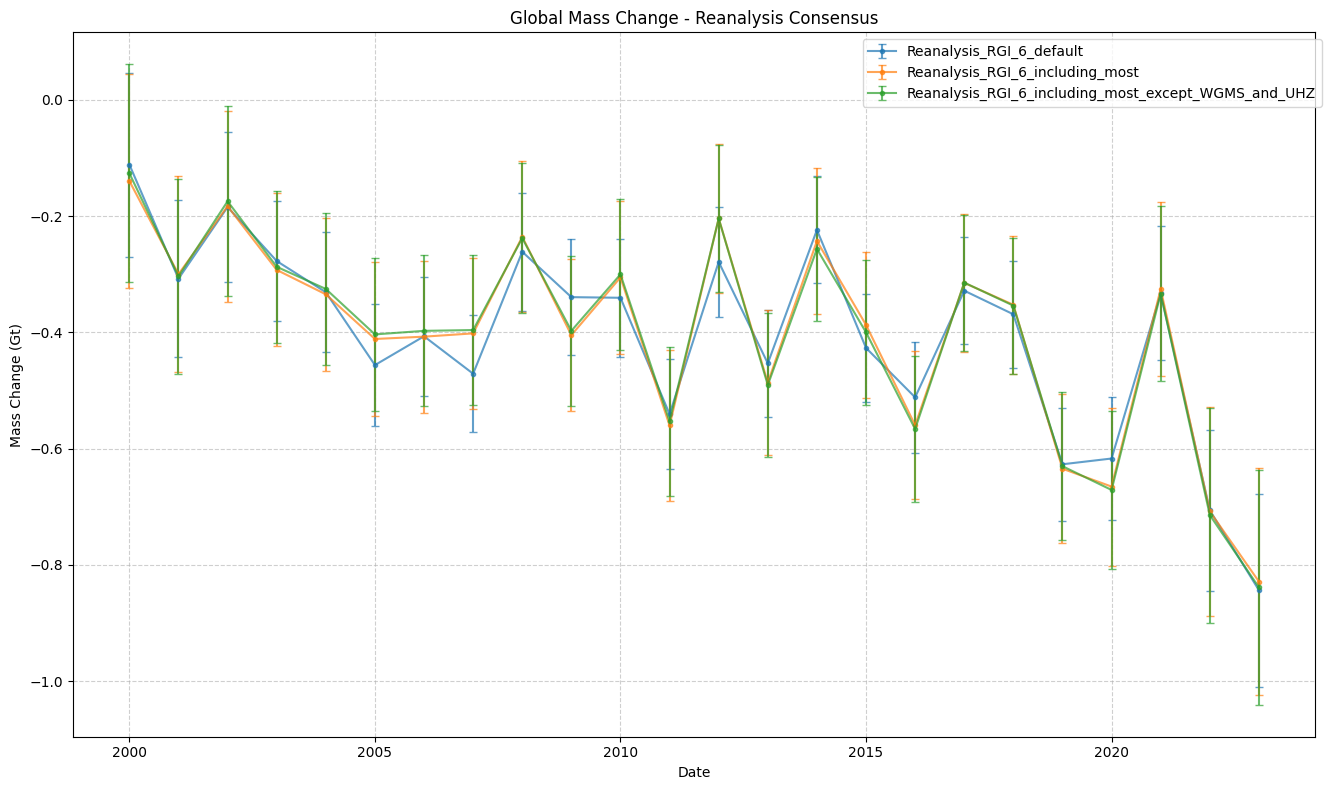

In [3]:
csv_files = sorted(glambie_runs.glob("Reanalysis*/0_*/consensus/csvs/global_mwe.csv"))
plt.figure(figsize=(14, 8))
for csv_file in csv_files:
    df = pd.read_csv(str(csv_file))
    date_col = next((c for c in df.columns if 'date' in c.lower()), df.columns[0])
    change_col = next((c for c in df.columns if 'change' in c.lower()), None)
    error_col = next((c for c in df.columns if 'error' in c.lower()), None)
    if change_col and error_col:
        path_parts = csv_file.parts
        label = next((part for part in path_parts if part.startswith('Reanalysis')), 'Unknown')
        plt.errorbar(df[date_col], df[change_col], yerr=df[error_col],
                        label=label, fmt='.-', capsize=3, alpha=0.7)

plt.title('Global Mass Change - Reanalysis Consensus')
plt.xlabel('Date')
plt.ylabel('Mass Change (Gt)')
plt.legend(bbox_to_anchor=(0.63, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

Loop


In [ ]:
for i in range(1, 19):
    csv_files = sorted(glambie_runs.glob(f"Reanalysis*/{i}_*/consensus/csvs/consensus_calendar_year_gt*.csv"))
    region_matches = list(glambie_runs.glob(f"Reanalysis*/{i}_*"))
    region_name = 'Unknown'
    if region_matches:
        folder_name = region_matches[0].name
        region_name = folder_name.split('_', 1)[1] if '_' in folder_name else folder_name
    plt.figure(figsize=(14, 8))
    for csv_file in csv_files:
        df = pd.read_csv(str(csv_file))
        date_col = next((c for c in df.columns if 'date' in c.lower()), df.columns[0])
        change_col = next((c for c in df.columns if 'change' in c.lower()), None)
        error_col = next((c for c in df.columns if 'error' in c.lower()), None)
        if change_col and error_col:
            path_parts = csv_file.parts
            label = next((part for part in path_parts if part.startswith('Reanalysis')), 'Unknown')
            plt.errorbar(df[date_col], df[change_col], yerr=df[error_col],
                        label=label, fmt='.-', capsize=3, alpha=0.7)
    plt.title(f'Mass Change - {region_name.title()} Region')
    plt.xlabel('Date')
    plt.ylabel('Mass Change (Gt)')
    plt.legend(bbox_to_anchor=(0.63, 1), loc='upper left')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()
